## EV Adoption Forecasting
As electric vehicle (EV) adoption surges, urban planners need to anticipate infrastructure needs—especially charging stations. Inadequate planning can lead to bottlenecks, impacting user satisfaction and hindering sustainability goals.

**Problem Statement:** Using the electric vehicle dataset (which includes information on EV populations, vehicle types, and possibly historical charging usage), create a model to forecast future EV adoption. For example, predict the number of electric vehicles in upcoming years based on the trends in the data.

**Goal:** Build a regression model that forecasts future EV adoption demand based on historical trends in EV growth, types of vehicles, and regional data.

**Dataset:** This dataset shows the number of vehicles that were registered by Washington State Department of Licensing (DOL) each month. The data is separated by county for passenger vehicles and trucks.hello

### Import Required Libraries

### pip install pandas numpy matplotlib seaborn scikit-learn # global env

In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Load Dataset

In [3]:
# Load data
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv")

### Explore and Understand the Data

In [4]:
df.head() # top 5 rows

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [5]:
# no of rows and cols
df.shape

(20819, 10)

In [6]:
# Data Types, class and memory alloc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [7]:
df.isnull().sum()

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

In [8]:
# Check if any column contain outliers.

# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


### Data Preprocessing

In [9]:
# Converts the "Date" column to actual datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Removes rows where "Date" conversion failed
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


Remove Outliers: Cap the values to the IQR bounds

In [10]:
# Cap the outliers - it keeps all the data while reducing the skew from extreme values.

df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


Line plot: EV growth over years

Bar chart: Region-wise EV adoption

Heatmap: Correlation between features

<Axes: >

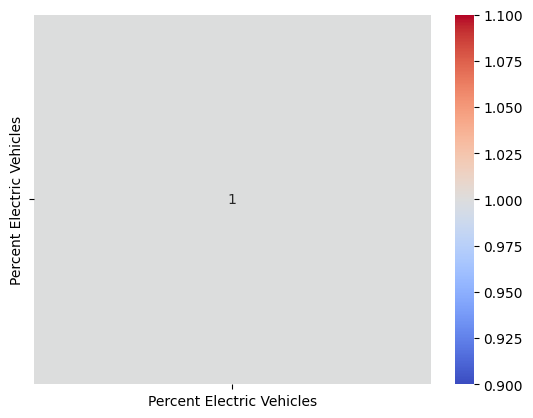

In [21]:
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')


Handle missing values (NaN)

Remove duplicates

Normalize date formats

In [25]:
print(df.columns)

Index(['Date', 'County', 'State', 'Vehicle Primary Use',
       'Battery Electric Vehicles (BEVs)',
       'Plug-In Hybrid Electric Vehicles (PHEVs)',
       'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total',
       'Total Vehicles', 'Percent Electric Vehicles'],
      dtype='object')


In [24]:
df.drop_duplicates(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])


XGBoost or Random Forest Regressor

Time Series forecasting (if data is time-based)

In [27]:
# Convert 'Date' to datetime and extract year (optional)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Select numeric columns for features
features = ['Year', 'Total Vehicles', 'Non-Electric Vehicle Total']
target = 'Electric Vehicle (EV) Total'

X = df[features]
y = df[target]


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
print(df.columns)


Index(['Date', 'County', 'State', 'Vehicle Primary Use',
       'Battery Electric Vehicles (BEVs)',
       'Plug-In Hybrid Electric Vehicles (PHEVs)',
       'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total',
       'Total Vehicles', 'Percent Electric Vehicles'],
      dtype='object')
